# The data will be read from the files and taken into a list

## Imorting dependencies

In [1]:
import pandas as pd
import os

### Defining File path and reading from the defined path

In [2]:
directory_path = r'C:\Masters Degree\Empirical Data\DataSet'
csv_files = sorted([f for f in os.listdir(directory_path) if f.endswith('.txt')])
df_list = []

In [4]:
for filename in csv_files:
    print(filename)
    df = pd.read_csv(os.path.join(directory_path, filename))
    freq_bands = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']
    df = df.loc[:, freq_bands]
    df_list.append(df)

data_collection_EEG_Abdullah1.txt
data_collection_EEG_Andrew1.txt
data_collection_EEG_Cleo1.txt
data_collection_EEG_Cris1.txt
data_collection_EEG_Shane1.txt
data_collection_EEG_abhishek.txt
data_collection_EEG_aumkar.txt
data_collection_EEG_dhyey.txt
data_collection_EEG_kevin1.txt
data_collection_EEG_malem1.txt
data_collection_EEG_rahul1.txt
data_collection_EEG_srijit1.txt
data_collection_EEG_vishwa1.txt


### MNE library to help us analyze the signal data

In [5]:
#The following library is imported to carry out thE independent component analysis for the channel data collected
!pip install mne
import mne

In [6]:
print("Columns: ", df_list[0].columns)
print("Total number of columns: ",len(df_list[0].columns))

Columns:  Index(['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1',
       'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4'],
      dtype='object')
Total number of columns:  14


In [7]:
#Create a copy of the original EEG datasets
import copy
df_raw_list = copy.deepcopy(df_list)
df_raw_list[0].head()

,EEG.AF3,EEG.F7,EEG.F3,EEG.FC5,EEG.T7,EEG.P7,EEG.O1,EEG.O2,EEG.P8,EEG.T8,EEG.FC6,EEG.F4,EEG.F8,EEG.AF4
0,4290.769043,4283.077148,4305.512695,4300.769043,4295.897461,4458.333496,4297.820313,4277.179688,4265.128418,4264.615234,4444.358887,4472.820313,4365.769043,4405.769043
1,4292.820313,4292.436035,4312.820313,4308.461426,4298.205078,4450.384766,4317.051270,4282.436035,4275.384766,4270.512695,4451.282227,4479.102539,4367.051270,4406.666504
2,4296.666504,4295.897461,4311.922852,4306.153809,4297.307617,4444.871582,4327.051270,4291.922852,4281.794922,4276.922852,4459.487305,4489.615234,4374.615234,4412.051270
3,4295.641113,4281.410156,4310.128418,4296.666504,4293.461426,4436.794922,4330.256348,4299.487305,4281.410156,4278.846191,4457.051270,4491.666504,4374.871582,4412.948730
4,4292.948730,4273.974121,4307.820313,4294.358887,4292.820313,4417.692383,4318.461426,4298.077148,4282.692383,4275.000000,4453.589844,4488.205078,4368.333496,4406.794922


In [8]:
df_raw_list[0].shape  #this is abdullah's data

(7814, 14)

In [9]:
df_raw_list[1].shape #this is Andrew

(7816, 14)

### Independent Component Analysis

In [10]:
import numpy as np
import mne

def apply_ica(df_list):
    sfreq = 128.0
    n_components = 6
    method = 'fastica'
    random_state = 42
    l_freq = 1.0
    h_freq = 50.0
    filter_length = 'auto'
    fir_design = 'firwin'
    ref_channels = 'average'
    ch_names = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']
    eog_ch_names = ['EEG.AF3', 'EEG.F7', 'EEG.F8', 'EEG.AF4', 'EEG.F3', 'EEG.F4']
    
    preprocessed_data = []
    ica_objects = []
    
    for i, df in enumerate(df_list):
        data = df.to_numpy()
        info = mne.create_info(ch_names, sfreq, ch_types=['eeg'] * 14)
        raw = mne.io.RawArray(data.T, info)

        eog_indices = [ch_names.index(ch) for ch in eog_ch_names]
        ch_types = ['eog' if i in eog_indices else 'eeg' for i in range(len(ch_names))]
        raw.set_channel_types(dict(zip(ch_names, ch_types)))

        raw = filter_data(raw, l_freq, h_freq, filter_length, fir_design)
        raw.set_eeg_reference(ref_channels=ref_channels)

        ica = create_and_apply_ica(raw, n_components, method, random_state)
        
        ica_objects.append(ica)
        preprocessed_data.append(pd.DataFrame(raw.get_data().T, columns=ch_names))

    return (preprocessed_data,ica_objects) 

def filter_data(raw, l_freq, h_freq, filter_length, fir_design):
    raw.filter(l_freq=l_freq, h_freq=h_freq, l_trans_bandwidth='auto', h_trans_bandwidth='auto', filter_length=filter_length, fir_design=fir_design)
    return raw

def create_and_apply_ica(raw, n_components, method, random_state):
    ica = mne.preprocessing.ICA(n_components=n_components, method=method, random_state=random_state, max_iter=16000)
    ica.fit(raw)

    eog_epochs = mne.preprocessing.create_eog_epochs(raw, reject_by_annotation=False)
    eog_inds, eog_scores = ica.find_bads_eog(eog_epochs)
    ica.exclude += eog_inds
    ica.apply(raw)

    return ica

This code is a pipeline for processing EEG data using Independent Component Analysis (ICA) with the mne library. It takes raw EEG data (stored in a list of DataFrames), filters and prepares it, identifies and removes artifacts, and then returns both the processed data and ICA objects. Here's a breakdown of its functionality:

Setup and Configuration: Key parameters like sampling frequency, the number of ICA components, filtering limits, and channel names are defined at the start. These parameters configure the preprocessing steps for EEG data to optimize ICA application.

Loop Over DataFrames: The code iterates over each DataFrame in df_list. Each DataFrame represents EEG data, with each row as a time point and each column as a channel. Inside the loop:

It converts each DataFrame to a NumPy array to feed it into the MNE library.
A new RawArray object is created using this data and the predefined channel information.
Setting Channel Types: It designates specific channels as EOG channels (for detecting eye movements) and others as EEG channels. This distinction allows the ICA algorithm to target the EOG channels, which commonly contain artifacts, for separation.

Filtering and Referencing: The data undergoes a band-pass filter (keeping frequencies between 1 and 50 Hz) to remove unwanted noise and is referenced to a common average to standardize the signal.

ICA Application: The create_and_apply_ica function applies ICA to identify and separate components, especially for artifact removal (like eye movements and blinks):

The ICA algorithm fits to the data, estimating the independent components.
EOG artifacts are identified by correlating the components with eye movement patterns.
These identified components are excluded from the signal.
Storing Results: Finally, the processed EEG data (free from EOG artifacts) is saved as a DataFrame in preprocessed_data. The ICA objects, containing the artifact removal information, are saved in ica_objects.

Overall Purpose
This pipeline effectively cleans EEG data by removing artifacts through ICA, making it more suitable for further analysis by removing noise and standardizing channels. The output includes:

preprocessed_data: Cleaned EEG data for each input dataset.
ica_objects: ICA objects that retain the independent components and any excluded components for further inspection or reuse.

In [11]:
df_list, ica_objects = apply_ica(df_list)

Creating RawArray with float64 data, n_channels=14, n_times=7814
    Range : 0 ... 7813 =      0.000 ...    61.039 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.5s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.AF4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected: 4
Not sett

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Selecting by number: 6 components
Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 99 significant peaks
Number of EOG events detected: 99
Not setting metadata
99 matching events found
No baseline correction applied
Using data

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F7 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected: 5
Not setting metadata
5 matching events found
No baseline correction applied
Using data from preloaded Raw for 5 events and 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.0s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F7 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 17 significant peaks
Number of EOG events detected: 17
Not setting metadata
17 matching events found
No baseline correction applied
Using data from preloaded Raw for 17 events 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected: 4
Not setting metadata
4 matching events found
No baseline correction applied
Using data from preloaded Raw for 4 events and 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.AF4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected: 4
Not setting metadata
4 matching events found
No baseline correction applied
Using data from preloaded Raw for 4 events and 129 original time points ...
0 bad epochs dropped
Using EOG channels: EEG.AF3, EEG.F7, EEG.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 99 significant peaks
Number of EOG events detected: 99
Not setting metadata
99 matching events found
No baseline correction applied
Using data from preloaded Raw for 99 events and 129 original time p

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F7 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 5 significant peaks
Number of EOG events detected: 5
Not setting metadata
5 matching events found
No baseline correction applied
Using data from preloaded Raw for 5 events and 129 original time points ...
0 bad epochs dropped
Using EOG channels: EEG.AF3, EEG.F7, EEG.F

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.0s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F7 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 17 significant peaks
Number of EOG events detected: 17
Not setting metadata
17 matching events found
No baseline correction applied
Using data from preloaded Raw for 17 events 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 4 significant peaks
Number of EOG events detected: 4
Not setting metadata
4 matching events found
No baseline correction applied
Using data from preloaded Raw for 4 events and 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 200 significant peaks
Number of EOG events detected: 200
Not setting metadata
200 matching events found
No baseline correction applied
Using data from preloaded Raw for 200 eve

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Fo

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Applying a custom ('EEG',) reference.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.F8 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 210 significant peaks
Nu

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 0.0s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.AF4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=7814
    Range : 0 ... 7813 =      0.000 ...    61.039 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 8 channels (please be pat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=7815
    Range : 0 ... 7814 =      0.000 ...    61.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 423 samples (3.305 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Fitting ICA to data using 8 channels (please be pat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Found 137 significant peaks
Number of EOG events detected: 137
Not setting metadata
137 matching events found
No baseline correction applied
Using data from preloaded Raw for 137 events and 129 original time points ...
2 bad epochs dropped
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=15561
    Range : 0 ... 15560 =      0.000 ...   121.562 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 H

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 11 significant peaks
Number of EOG events detected: 11
Not setting metadata
11 matching events found
No baseline correction applied
Using data from preloaded Raw for 11 events and 129 original time points ...
0 bad epochs dropped
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
Applying ICA to Raw instance
    Transforming to ICA space (6 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components
Creating RawArray with float64 data, n_channels=14, n_times=7815
    Range : 0 ... 7814 =      0.000 ...    61.047 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


Fitting ICA took 0.1s.
Using EOG channels: EEG.AF3, EEG.F7, EEG.F3, EEG.F4, EEG.F8, EEG.AF4
EOG channel index for this subject is: [ 0  1  2 11 12 13]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EEG.AF4 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 6 significant peaks
Number of EOG events detected: 6
Not setting metadata
6 matching events found
No baseline correction applied
Using data from preloaded Raw for 6 events and

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


# Visualizing the data

In [12]:
import matplotlib.pyplot as plt
def visualize(df_original, df_filtered, ica_object):
    ch_names = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5', 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4', 'EEG.F8', 'EEG.AF4']
    info = mne.create_info(ch_names, sfreq=128, ch_types='eeg')

    raw_original = mne.io.RawArray(df_original.T.to_numpy(), info)
    raw_filtered = mne.io.RawArray(df_filtered.T.to_numpy(), info)

    start_time = 0
    
    raw_filtered.plot(scalings='auto', start=start_time, show=False)
    plt.show()

    ica_object.plot_sources(raw_filtered, start=start_time, show=False)
    plt.show()

This code provides a way to visualize and compare EEG data before and after applying ICA artifact removal. It creates two RawArray objects in MNE for the original and filtered data, each with the necessary channel information. The visualize function then plots:

Filtered EEG Data: This plot shows the EEG signals after artifact removal, allowing you to observe cleaner data, free from noise like eye movements or other artifacts.

ICA Sources: By plotting the ICA sources, you can see the independent components identified by ICA within the filtered data. This visualization helps verify whether the correct artifacts have been isolated and removed.

The function effectively enables quality checks by visually comparing the EEG data before and after ICA application.

Creating RawArray with float64 data, n_channels=14, n_times=7814
    Range : 0 ... 7813 =      0.000 ...    61.039 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=7814
    Range : 0 ... 7813 =      0.000 ...    61.039 secs
Ready.
Using matplotlib as 2D backend.


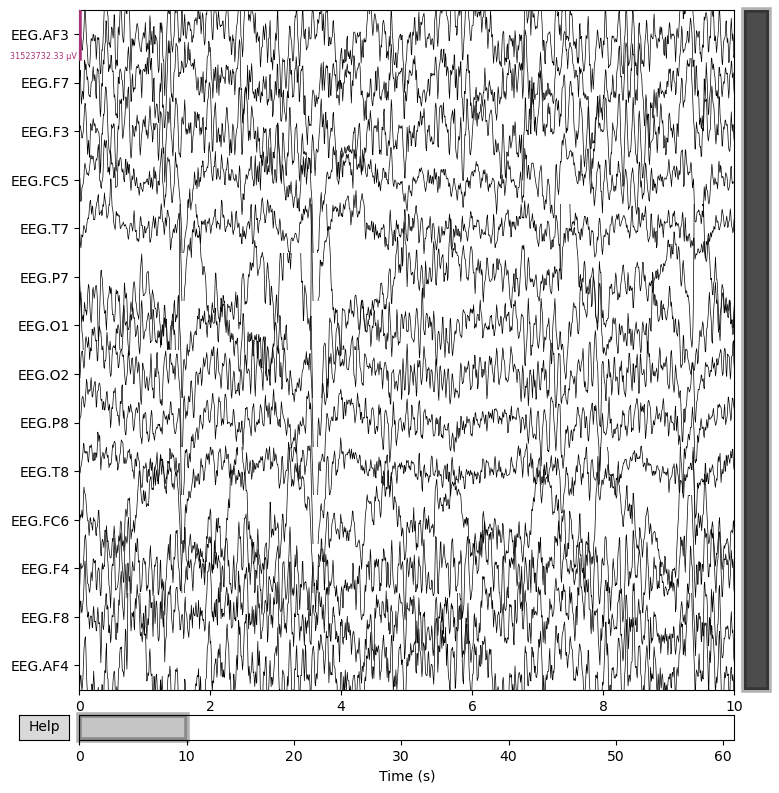

Creating RawArray with float64 data, n_channels=6, n_times=7814
    Range : 0 ... 7813 =      0.000 ...    61.039 secs
Ready.


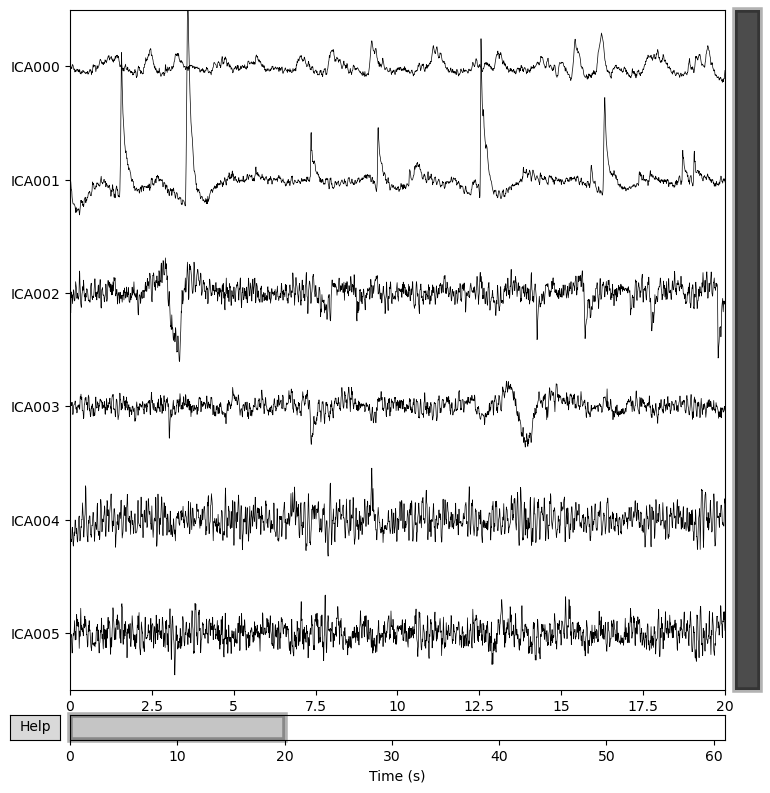

In [13]:
visualize(df_raw_list[0], df_list[0], ica_objects[0])

This code segments or "windows" the EEG data into smaller, fixed-duration chunks. Here’s how it works:

Define Window Size: Given the sampling_rate (default 256 Hz) and window_duration (default 3 seconds), it calculates the number of samples per window (window_size), which is the product of the sampling rate and duration (e.g., 256 * 3 = 768 samples for a 3-second window).

Loop Over DataFrames: For each DataFrame in df_list (representing an EEG recording), the code slices the data into 3-second chunks (windows). The window boundaries (start and end) are adjusted with each iteration to create consecutive, non-overlapping windows.

Store Windows: Each window is converted to a NumPy array and appended to a list of windows for that DataFrame. All windowed data for each EEG recording is added to windowed_data.

Return: The windowed_data list contains windowed segments for each EEG recording, ready for further processing.

When you access df_list[0], you’ll see a list of 3-second EEG data windows from the first DataFrame in df_list.

In [14]:
def window_data(df_list, sampling_rate=256, window_duration=3):
    window_size = sampling_rate * window_duration
    
    windowed_data = []

    for df in df_list:
        windows = []
        start = 0
        end = window_size

        while end <= len(df):
            window = df.iloc[start:end].to_numpy().T
            windows.append(window)

            start += window_size
            end += window_size

        windowed_data.append(windows)

    return windowed_data

df_list = window_data(df_list)
df_list[0]

[array([[4290.769043, 4292.820313, 4296.666504, ..., 4293.717773,
         4293.461426, 4297.692383],
        [4283.077148, 4292.436035, 4295.897461, ..., 4273.077148,
         4274.871582, 4271.538574],
        [4305.512695, 4312.820313, 4311.922852, ..., 4293.846191,
         4296.922852, 4300.      ],
        ...,
        [4472.820313, 4479.102539, 4489.615234, ..., 4467.820313,
         4469.230957, 4472.05127 ],
        [4365.769043, 4367.05127 , 4374.615234, ..., 4337.05127 ,
         4334.871582, 4339.743652],
        [4405.769043, 4406.666504, 4412.05127 , ..., 4401.538574,
         4393.974121, 4396.666504]]),
 array([[4303.205078, 4303.205078, 4303.333496, ..., 4294.871582,
         4295.256348, 4295.769043],
        [4264.871582, 4265.      , 4270.641113, ..., 4278.974121,
         4284.615234, 4282.820313],
        [4305.      , 4310.897461, 4314.871582, ..., 4309.358887,
         4312.05127 , 4310.897461],
        ...,
        [4474.230957, 4482.692383, 4489.743652, ..., 4

1. Calculate Power in Each Band: Calculate the power spectral density (PSD) for each frequency band. 
2. 
Estimate Valence and Arousal: Use weighted sums or mappings from research on EEG-based emotion recognition to calculate valence and arousal scores 3. 
Plot the Valence-Arousal Coordinates.

In [15]:
import numpy as np
import pandas as pd
from scipy.signal import welch

def extract_features(df_list):
    # Define frequency bands of interest
    freq_bands = {
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma':(30,40),
    }

    features_list = []

    # Iterate over windows for each user
    for user_windows in df_list:
        features = []

        for window in user_windows:
            psd_features = []

            for channel in window:
                nperseg = min(len(channel), 128)
                freqs, psd = welch(channel, fs=128, nperseg=nperseg, nfft=nperseg)

                band_powers = []
                # Calculate power for each frequency band
                for fmin, fmax in freq_bands.values():
                    band_power = np.sum(psd[(freqs >= fmin) & (freqs <= fmax)])
                    band_powers.append(band_power)

                psd_features.append(band_powers)
                
            # Flatten and store features for this window
            features.append(np.array(psd_features).flatten())

        # Create DataFrame with feature names for channels and bands
        column_names = [f'Ch{ch}_{band}' for ch in range(len(window)) for band in freq_bands.keys()]
        features_df = pd.DataFrame(features, columns=column_names)
        features_list.append(features_df)

    return features_list


This code extracts frequency band power features from EEG data for each windowed segment, a common method for analyzing brainwave activity.

Here’s the purpose of each part:

Define Frequency Bands: The frequency bands (theta, alpha, beta, and gamma) are set to capture distinct neural activities within these ranges. These bands are relevant to EEG analysis, as they correspond to different cognitive and mental states.

Iterate Over Windows: For each user’s windowed data (created by the window_data function), the code extracts features from each window segment. This approach allows you to analyze EEG data at a high temporal resolution, giving insights into brain activity over short intervals.

Power Spectral Density (PSD) Calculation: Using Welch’s method, the code estimates the PSD for each EEG channel in a window. PSD represents the power of each frequency component, helping to quantify activity in specific frequency bands.

Band Power Calculation: The power for each frequency band is summed from the PSD values within the band range, representing the energy in each band, per channel. Band power is a useful feature in EEG analysis as it reflects the amplitude of neural oscillations in those ranges.

Feature Storage: Each band power is stored in a structured DataFrame, with columns named to indicate the channel and band (e.g., "Ch1_theta"), making it easier to understand and process later.

In summary, this function produces a feature set for each user, where each window has summarized power metrics across frequency bands and channels, essential for classifying or interpreting neural states. The output, a list of DataFrames, is ready for further steps in EEG analysis or machine learning applications.

In [16]:
# Assuming df_list is your list of dataframes
features_list = extract_features(df_list)  # Run the feature extraction

# Define weights for each frequency band, now including gamma
valence_weights = {'alpha': 0.6, 'beta': -0.5, 'theta': 0.4, 'gamma': -0.3}
arousal_weights = {'alpha': -0.4, 'beta': 0.7, 'theta': 0.2, 'gamma': 0.5}

# Initialize lists to store the valence and arousal scores for each user
valence_scores = []
arousal_scores = []

# Loop over each DataFrame (each user's features)
for features_df in features_list:
    # Aggregate the power for each band across all channels
    alpha_power = features_df[[col for col in features_df.columns if 'alpha' in col]].sum(axis=1)
    beta_power = features_df[[col for col in features_df.columns if 'beta' in col]].sum(axis=1)
    theta_power = features_df[[col for col in features_df.columns if 'theta' in col]].sum(axis=1)
    gamma_power = features_df[[col for col in features_df.columns if 'gamma' in col]].sum(axis=1)
    
    # Calculate valence and arousal using the weighted sums
    valence = (
        valence_weights['alpha'] * alpha_power +
        valence_weights['beta'] * beta_power +
        valence_weights['theta'] * theta_power +
        valence_weights['gamma'] * gamma_power
    )
    arousal = (
        arousal_weights['alpha'] * alpha_power +
        arousal_weights['beta'] * beta_power +
        arousal_weights['theta'] * theta_power +
        arousal_weights['gamma'] * gamma_power
    )
    
    valence_scores.append(valence)
    arousal_scores.append(arousal)

# Combine all users' valence and arousal scores into a single DataFrame
valence_arousal_df = pd.DataFrame({
    'valence': pd.concat(valence_scores).reset_index(drop=True),
    'arousal': pd.concat(arousal_scores).reset_index(drop=True)
})


This code calculates valence and arousal scores based on the extracted frequency band powers from EEG data, useful metrics for interpreting emotional states. Here’s how each part contributes to achieving this:

Weights for Frequency Bands: valence_weights and arousal_weights specify the influence of each frequency band (alpha, beta, theta, gamma) on the overall valence and arousal. These weights reflect known associations: for example, high beta power is often linked to heightened arousal, while high alpha power might relate to relaxation or low arousal.

Power Aggregation: For each user, the power across all EEG channels is summed for each band (alpha, beta, theta, gamma) in the DataFrame of features (features_df). Summing across channels provides an overall measure of each band’s power per window, a step that condenses EEG data into simpler metrics.

Calculating Valence and Arousal: Using weighted sums, the code combines band powers to produce valence and arousal scores. This step leverages the weights to emphasize bands relevant to positive/negative (valence) and high/low energy (arousal) states, tailoring the scores for emotion interpretation.

Collecting Scores: valence_scores and arousal_scores store the calculated scores for each window. Finally, pd.concat gathers all users' valence and arousal data into a DataFrame (valence_arousal_df), which consolidates the emotion-related metrics and is ready for further analysis or visualization.

In essence, this process translates complex EEG signals into interpretable valence and arousal scores, indicating emotional characteristics that can support mood analysis or cognitive state monitoring.

In [17]:
# Define weights for valence and arousal across frequency bands
valence_weights = {'alpha': 0.6, 'beta': -0.5, 'theta': 0.4, 'gamma': -0.3}
arousal_weights = {'alpha': -0.4, 'beta': 0.7, 'theta': 0.2, 'gamma': 0.5}

def calculate_valence_arousal(features_list):
    valence_scores = []
    arousal_scores = []

    for features_df in features_list:
        # Aggregate the power for each band across all channels
        alpha_power = features_df[[col for col in features_df.columns if 'alpha' in col]].sum(axis=1)
        beta_power = features_df[[col for col in features_df.columns if 'beta' in col]].sum(axis=1)
        theta_power = features_df[[col for col in features_df.columns if 'theta' in col]].sum(axis=1)
        gamma_power = features_df[[col for col in features_df.columns if 'gamma' in col]].sum(axis=1)

        # Calculate valence and arousal
        valence = (
            valence_weights['alpha'] * alpha_power +
            valence_weights['beta'] * beta_power +
            valence_weights['theta'] * theta_power +
            valence_weights['gamma'] * gamma_power
        )
        arousal = (
            arousal_weights['alpha'] * alpha_power +
            arousal_weights['beta'] * beta_power +
            arousal_weights['theta'] * theta_power +
            arousal_weights['gamma'] * gamma_power
        )

        valence_scores.append(valence)
        arousal_scores.append(arousal)

    # Combine into a single DataFrame
    valence_arousal_df = pd.DataFrame({
        'valence': pd.concat(valence_scores).reset_index(drop=True),
        'arousal': pd.concat(arousal_scores).reset_index(drop=True)
    })
    
    return valence_arousal_df

This code serves to calculate valence and arousal scores from EEG frequency band power data, translating raw EEG features into interpretable emotional metrics. These scores help represent a subject's emotional state on two key dimensions: valence (positive vs. negative feelings) and arousal (high vs. low energy).

Key Steps and Utility
Frequency Band Power Aggregation: For each user (each features_df DataFrame in features_list), the code sums power across EEG channels for each frequency band—alpha, beta, theta, and gamma. This aggregation simplifies the data, consolidating power information per band across all channels into single values.

Weighted Valence and Arousal Calculation: Using predefined weights (valence_weights and arousal_weights), it calculates valence and arousal scores. These weights reflect how much each frequency band contributes to each emotional dimension; for example, alpha activity is positively weighted for valence, while beta is positively weighted for arousal. This step transforms raw power data into scores that align with theories on how brainwave frequencies relate to emotional states.

Data Consolidation: After calculating scores for each EEG data window, the code combines all users' scores into a single DataFrame, valence_arousal_df. This DataFrame stores valence and arousal as columns, with each row representing a windowed EEG segment.

Utility
This approach makes it easy to analyze emotional trends over time or across participants, providing a numerical basis for tracking emotional fluctuations during EEG recordings. This method is particularly useful for applications in cognitive neuroscience, affective computing, or user experience research, where monitoring and understanding emotional states is essential.

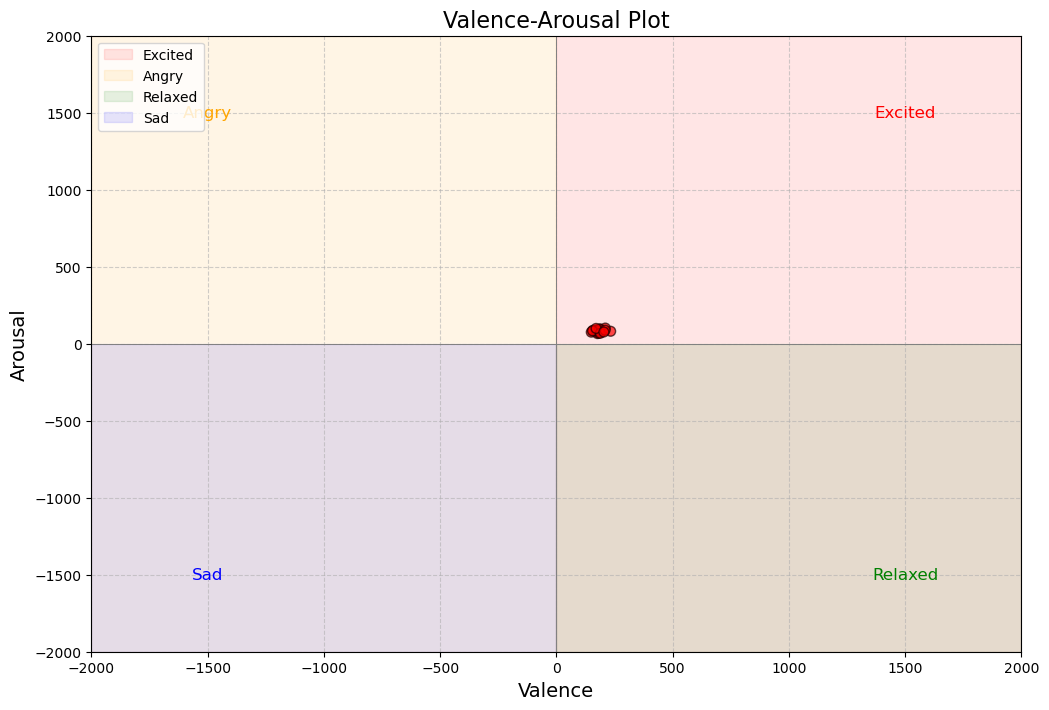

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_valence_arousal(valence_arousal_df, valence_limit=2000, arousal_limit=2000):
    # Filter outliers based on specified limits
    filtered_df = valence_arousal_df[(valence_arousal_df['valence'].abs() <= valence_limit) &
                                     (valence_arousal_df['arousal'].abs() <= arousal_limit)]

    plt.figure(figsize=(12, 8))

    # Define colors and labels for each quadrant
    colors = np.where((filtered_df['valence'] > 0) & (filtered_df['arousal'] > 0), 'red',  # Excited
                      np.where((filtered_df['valence'] < 0) & (filtered_df['arousal'] > 0), 'orange',  # Angry
                               np.where((filtered_df['valence'] > 0) & (filtered_df['arousal'] < 0), 'green',  # Relaxed
                                        'blue')))  # Sad

    # Scatter plot with colors based on quadrant
    scatter = plt.scatter(filtered_df['valence'], filtered_df['arousal'], c=colors, s=50, alpha=0.7, edgecolor='k')

    # Label axes and title
    plt.xlabel('Valence', fontsize=14)
    plt.ylabel('Arousal', fontsize=14)
    plt.title('Valence-Arousal Plot', fontsize=16)

    # Add quadrant grid lines and background colors
    plt.axhline(0, color='gray', linewidth=0.7)
    plt.axvline(0, color='gray', linewidth=0.7)
    
    # Fill in the quadrants with labels for the legend
    plt.fill_betweenx([-arousal_limit, arousal_limit], 0, valence_limit, color='red', alpha=0.1, label='Excited')
    plt.fill_betweenx([-arousal_limit, arousal_limit], -valence_limit, 0, color='orange', alpha=0.1, label='Angry')
    plt.fill_betweenx([-arousal_limit, 0], 0, valence_limit, color='green', alpha=0.1, label='Relaxed')
    plt.fill_betweenx([-arousal_limit, 0], -valence_limit, 0, color='blue', alpha=0.1, label='Sad')

    # Set axis limits to specified range
    plt.xlim(-valence_limit, valence_limit)
    plt.ylim(-arousal_limit, arousal_limit)

    # Add quadrant labels
    plt.text(1500, 1500, 'Excited', ha='center', va='center', fontsize=12, color='red')
    plt.text(-1500, 1500, 'Angry', ha='center', va='center', fontsize=12, color='orange')
    plt.text(1500, -1500, 'Relaxed', ha='center', va='center', fontsize=12, color='green')
    plt.text(-1500, -1500, 'Sad', ha='center', va='center', fontsize=12, color='blue')

    # Legend for color-coded points
    plt.legend(loc='upper left')
    
    # Add grid for better readability
    plt.grid(visible=True, linestyle='--', alpha=0.6)

    plt.show()

# Modified code to only process the first user in df_list
features_list = extract_features([df_list[11]])  # Extract features for the first DataFrame in df_list
valence_arousal_df = calculate_valence_arousal(features_list)  # Calculate valence and arousal
plot_valence_arousal(valence_arousal_df)  # Plot the valence-arousal graph


Key Components and Utility:
Data Filtering: The code first filters out data points (valence and arousal) that fall outside specified limits (valence_limit and arousal_limit). This helps remove any extreme or outlier values that may distort the visualization.

Color-Coded Quadrants: The plot divides the emotional space into four quadrants:

Excited (red): High valence, high arousal.
Angry (orange): Low valence, high arousal.
Relaxed (green): High valence, low arousal.
Sad (blue): Low valence, low arousal.
Each data point is colored according to the quadrant it falls into, making it easier to categorize the emotional states.

Scatter Plot: A scatter plot visualizes the relationship between valence and arousal for each data point. This plot allows easy identification of emotional trends or clusters, which can be helpful for:

Analyzing emotional responses to different stimuli or events.
Understanding how different users' emotions evolve over time.
Identifying patterns, such as users who tend to be more excited or relaxed.
Quadrant Background and Labels: The plot visually highlights each quadrant with light background color fills and labels. This provides clarity in interpreting where the data points lie in terms of emotional states, aiding in further analysis of the emotional responses.

Gridlines and Axis Limits: The plot includes gridlines and axis limits for better readability, making it easier to locate data points within the quadrants.

Legend: The legend identifies the colors representing each emotional state, improving the plot's interpretability.

Overall Utility:
This plot provides an intuitive way to visualize and understand the relationship between valence and arousal scores, translating complex EEG data into a more accessible format. It is especially useful for:

Emotion analysis: Understanding how emotional states change over time or in response to specific events.
Psychological studies: Exploring emotional responses based on cognitive tasks or stimuli.
Real-time emotional feedback: Providing feedback in applications like biofeedback, gaming, or cognitive load assessment.
In short, this code allows researchers and practitioners to visually assess and interpret emotional states based on EEG data, facilitating better decision-making and understanding of the underlying emotional dynamics.

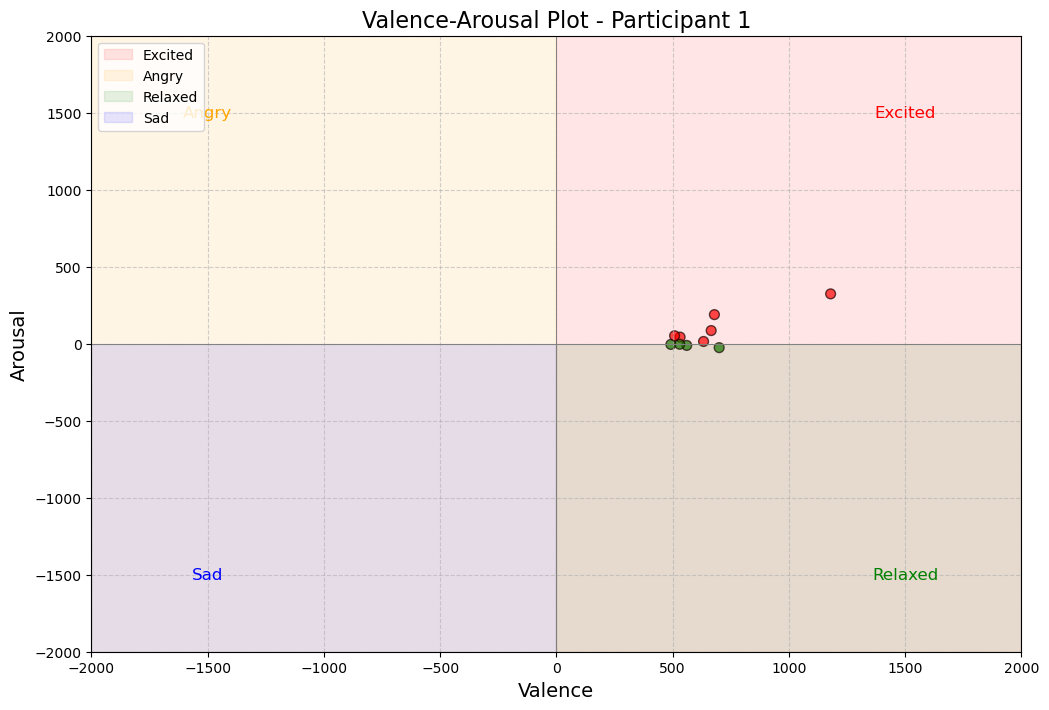

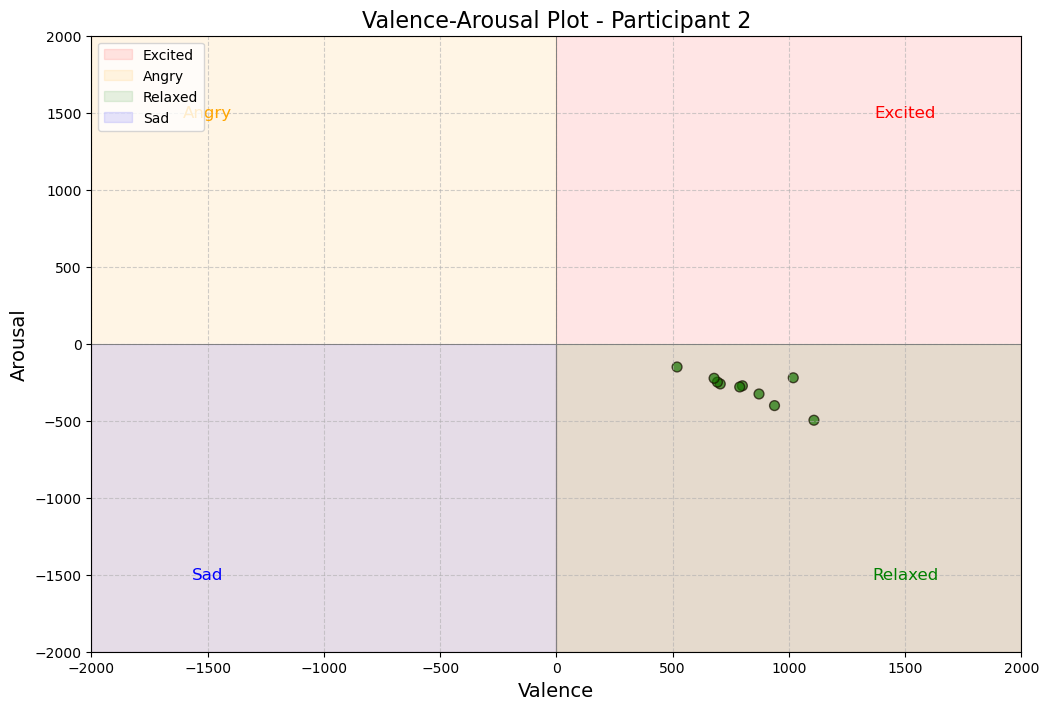

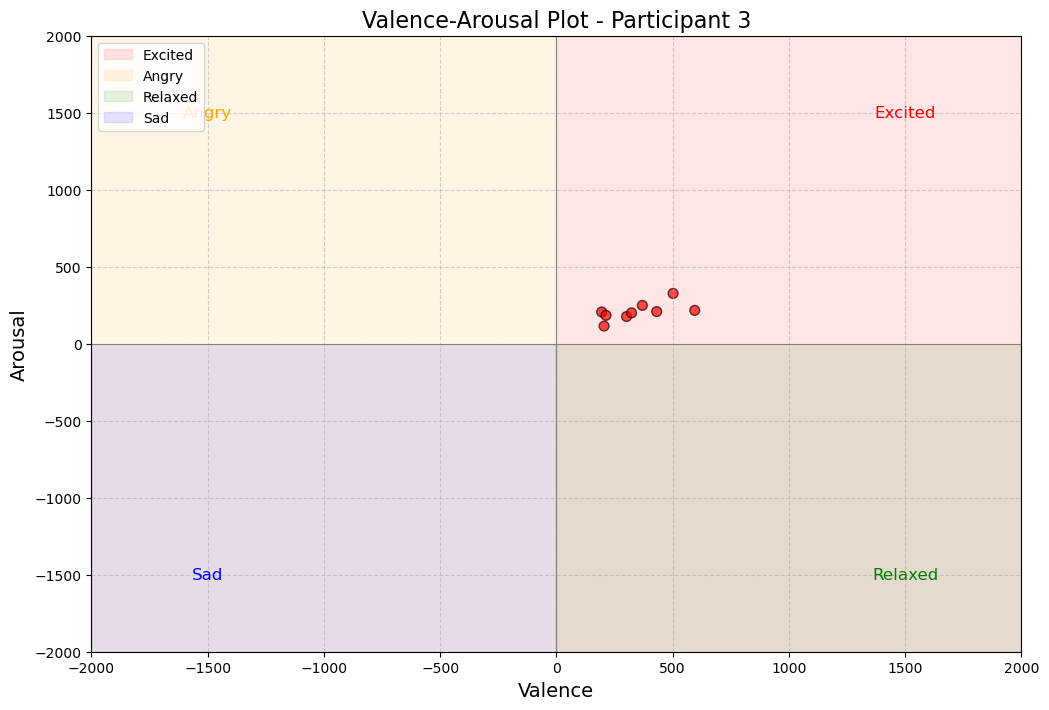

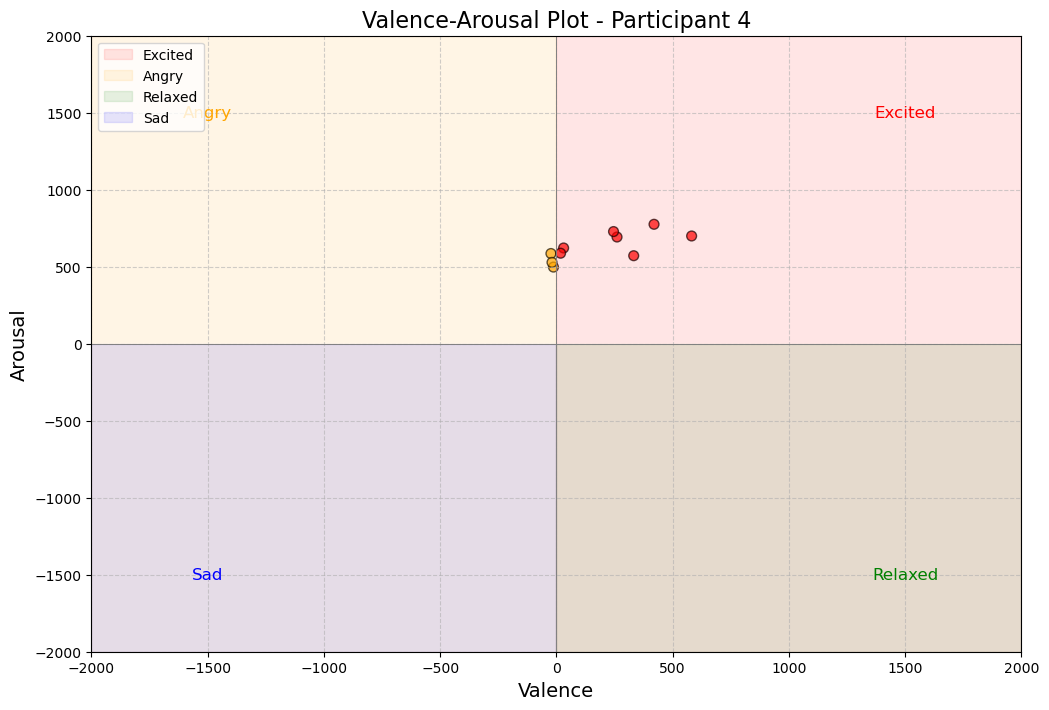

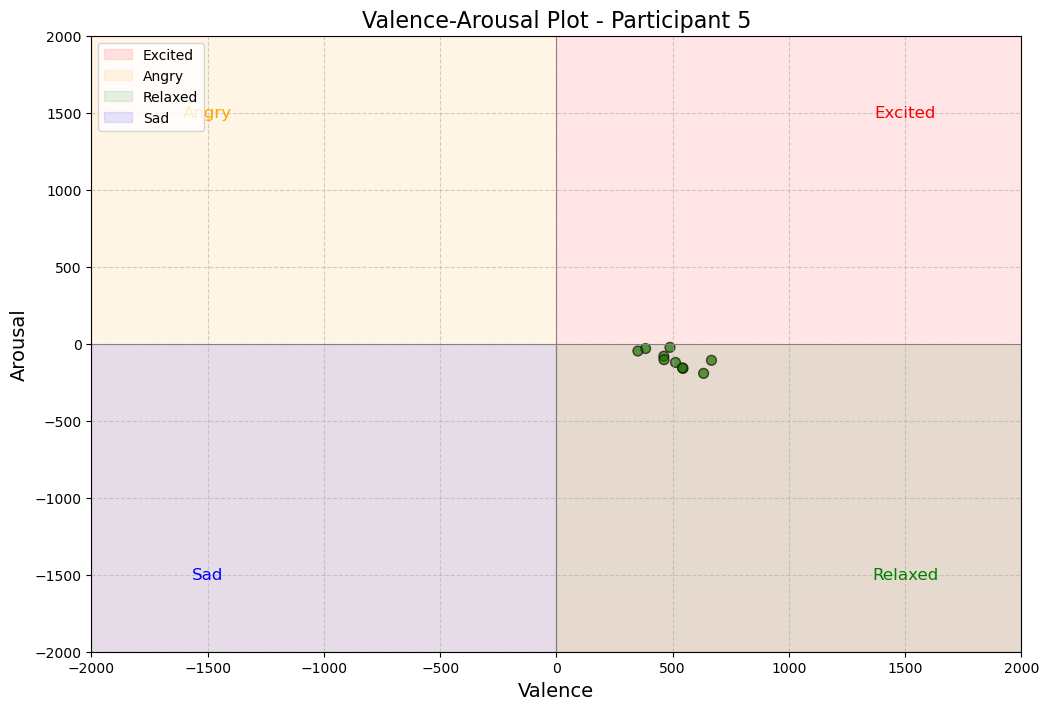

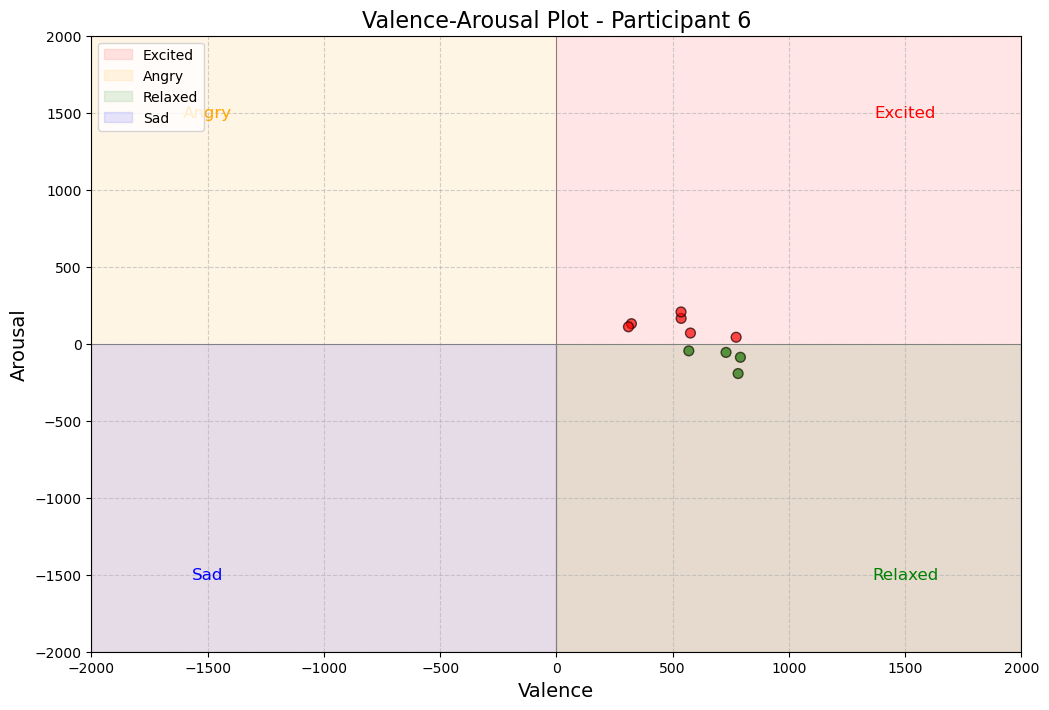

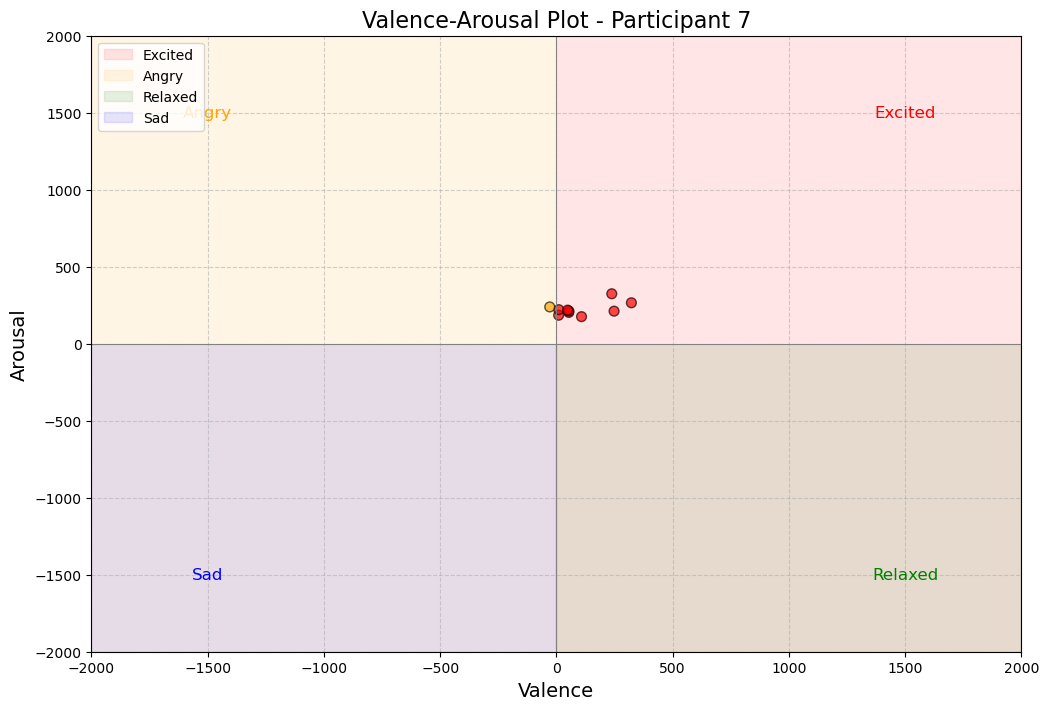

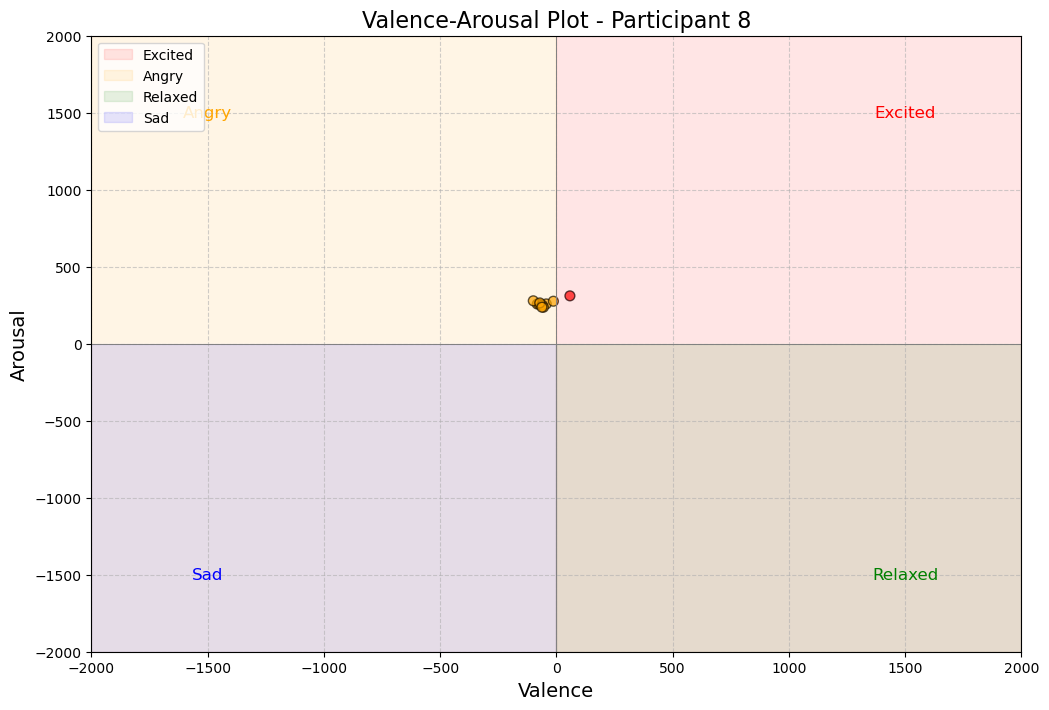

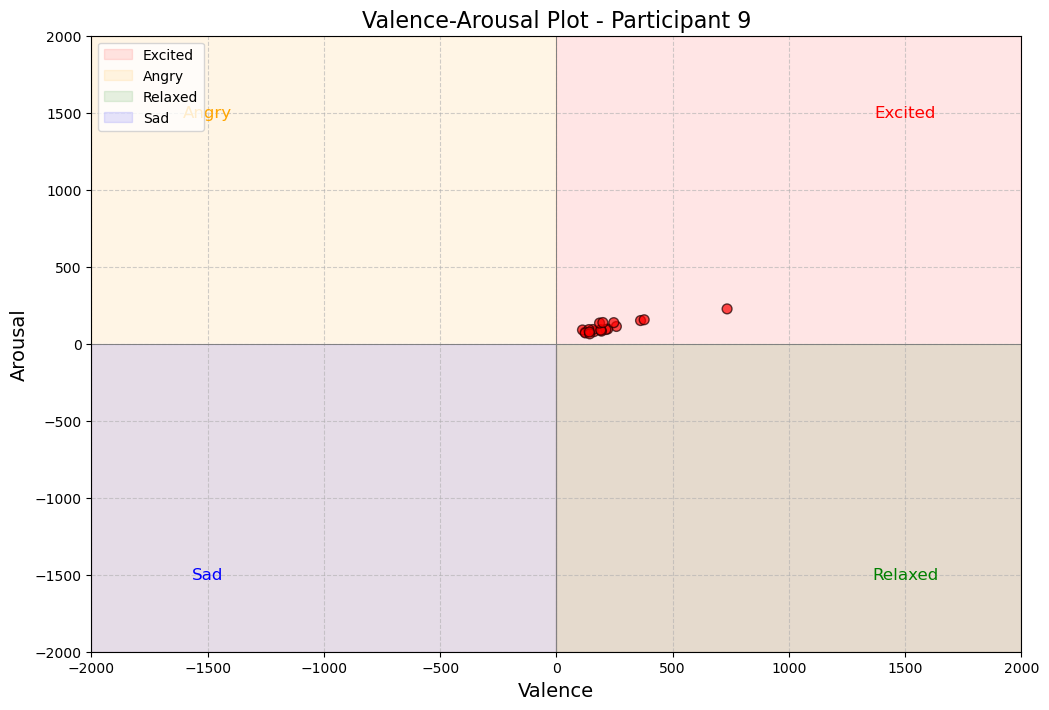

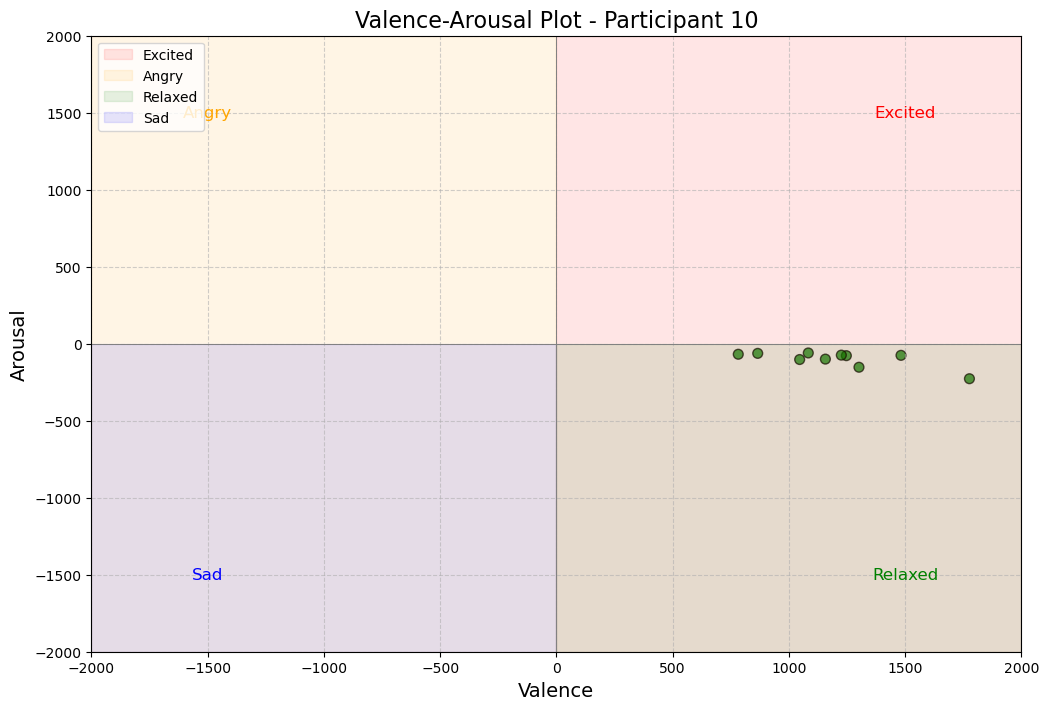

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_valence_arousal_for_all_participants(df_list, valence_limit=2000, arousal_limit=2000):
    # Loop over each participant in df_list
    for i, participant_df in enumerate(df_list):
        # Extract features and calculate valence-arousal for the current participant
        features_list = extract_features([participant_df])  # Extract features for this participant
        valence_arousal_df = calculate_valence_arousal(features_list)  # Calculate valence-arousal

        # Filter outliers based on specified limits
        filtered_df = valence_arousal_df[(valence_arousal_df['valence'].abs() <= valence_limit) &
                                         (valence_arousal_df['arousal'].abs() <= arousal_limit)]

        plt.figure(figsize=(12, 8))

        # Define colors and labels for each quadrant
        colors = np.where((filtered_df['valence'] > 0) & (filtered_df['arousal'] > 0), 'red',  # Excited
                          np.where((filtered_df['valence'] < 0) & (filtered_df['arousal'] > 0), 'orange',  # Angry
                                   np.where((filtered_df['valence'] > 0) & (filtered_df['arousal'] < 0), 'green',  # Relaxed
                                            'blue')))  # Sad

        # Scatter plot with colors based on quadrant
        scatter = plt.scatter(filtered_df['valence'], filtered_df['arousal'], c=colors, s=50, alpha=0.7, edgecolor='k')

        # Label axes and title
        plt.xlabel('Valence', fontsize=14)
        plt.ylabel('Arousal', fontsize=14)
        plt.title(f'Valence-Arousal Plot - Participant {i+1}', fontsize=16)

        # Add quadrant grid lines and background colors
        plt.axhline(0, color='gray', linewidth=0.7)
        plt.axvline(0, color='gray', linewidth=0.7)

        # Fill in the quadrants with labels for the legend
        plt.fill_betweenx([-arousal_limit, arousal_limit], 0, valence_limit, color='red', alpha=0.1, label='Excited')
        plt.fill_betweenx([-arousal_limit, arousal_limit], -valence_limit, 0, color='orange', alpha=0.1, label='Angry')
        plt.fill_betweenx([-arousal_limit, 0], 0, valence_limit, color='green', alpha=0.1, label='Relaxed')
        plt.fill_betweenx([-arousal_limit, 0], -valence_limit, 0, color='blue', alpha=0.1, label='Sad')

        # Set axis limits to specified range
        plt.xlim(-valence_limit, valence_limit)
        plt.ylim(-arousal_limit, arousal_limit)

        # Add quadrant labels
        plt.text(1500, 1500, 'Excited', ha='center', va='center', fontsize=12, color='red')
        plt.text(-1500, 1500, 'Angry', ha='center', va='center', fontsize=12, color='orange')
        plt.text(1500, -1500, 'Relaxed', ha='center', va='center', fontsize=12, color='green')
        plt.text(-1500, -1500, 'Sad', ha='center', va='center', fontsize=12, color='blue')

        # Legend for color-coded points
        plt.legend(loc='upper left')

        # Add grid for better readability
        plt.grid(visible=True, linestyle='--', alpha=0.6)

        # Show plot for the current participant
        plt.show()

# Example usage:
# Assuming df_list contains EEG data for all 9 participants
plot_valence_arousal_for_all_participants(df_list)


### We now have each participant's valence arousal plane cordinates that maps their emotions. I now need to work on a few exploratory stuff

### 1. Extract the cordinates from the valence arousal plane for each participant
### 2. Convert the cordinates into a time series animation to show changing emotion over time

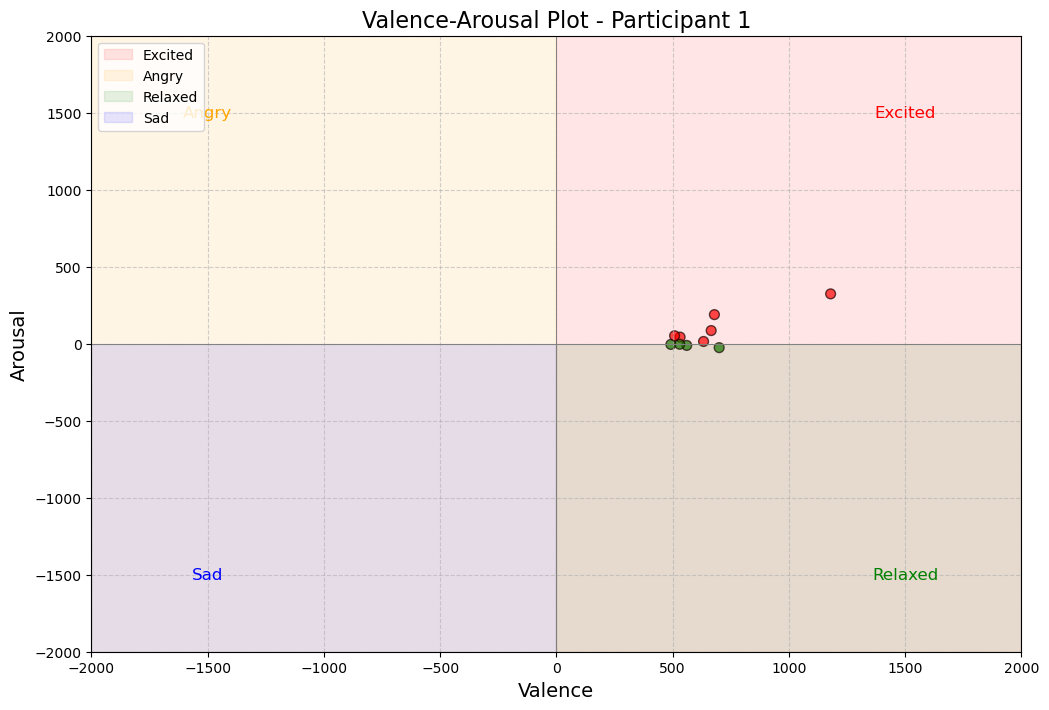

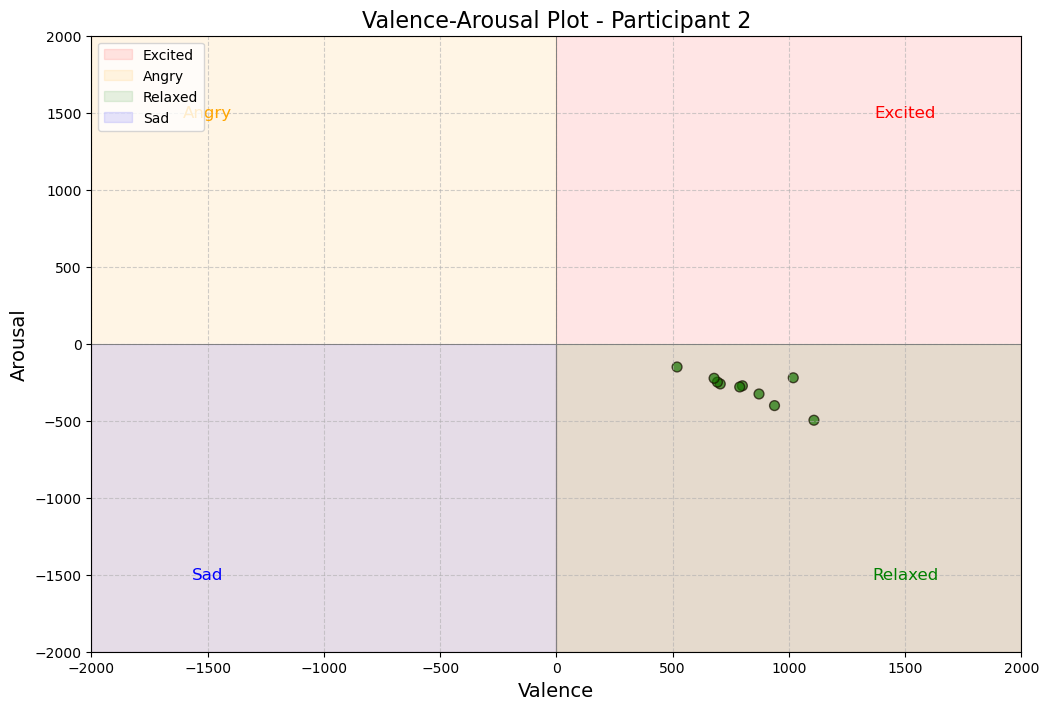

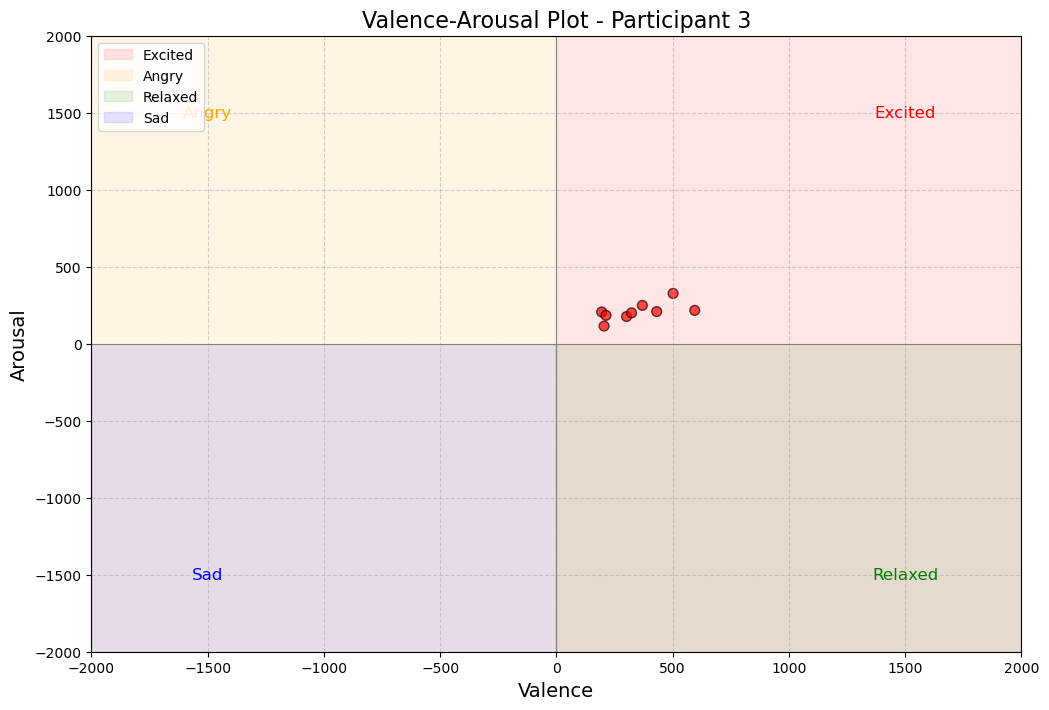

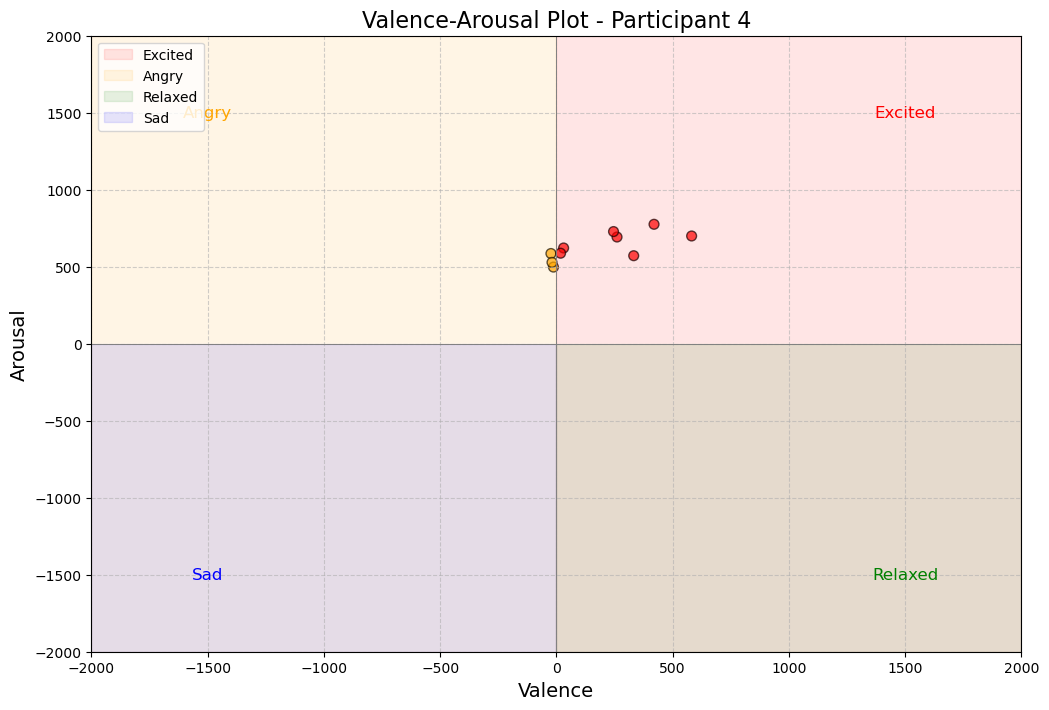

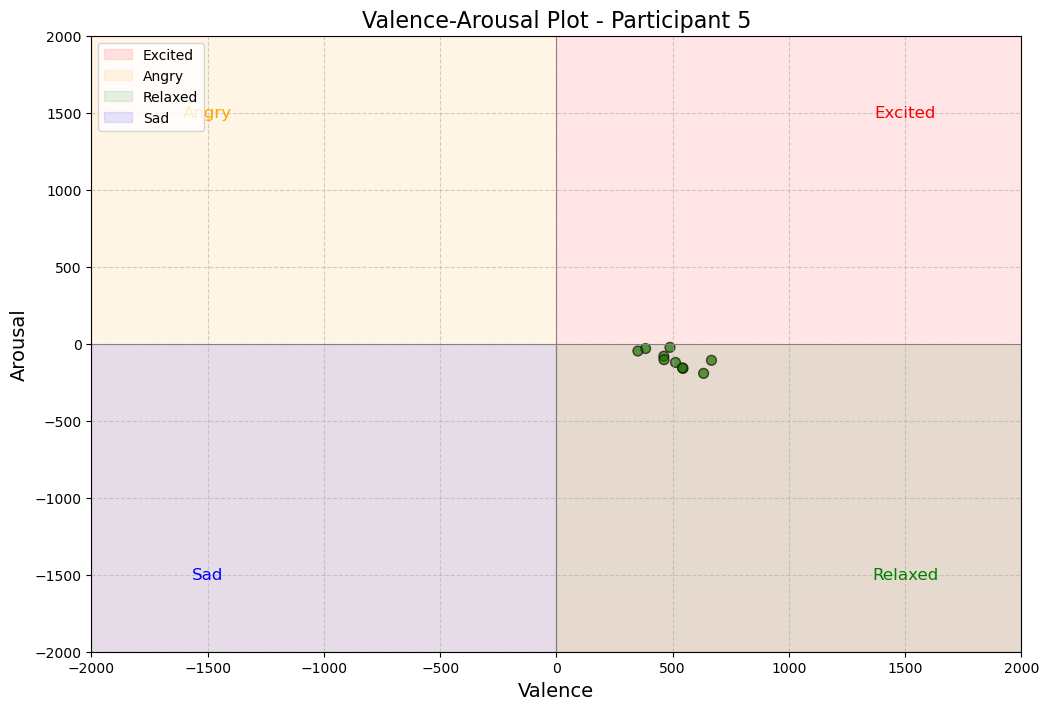

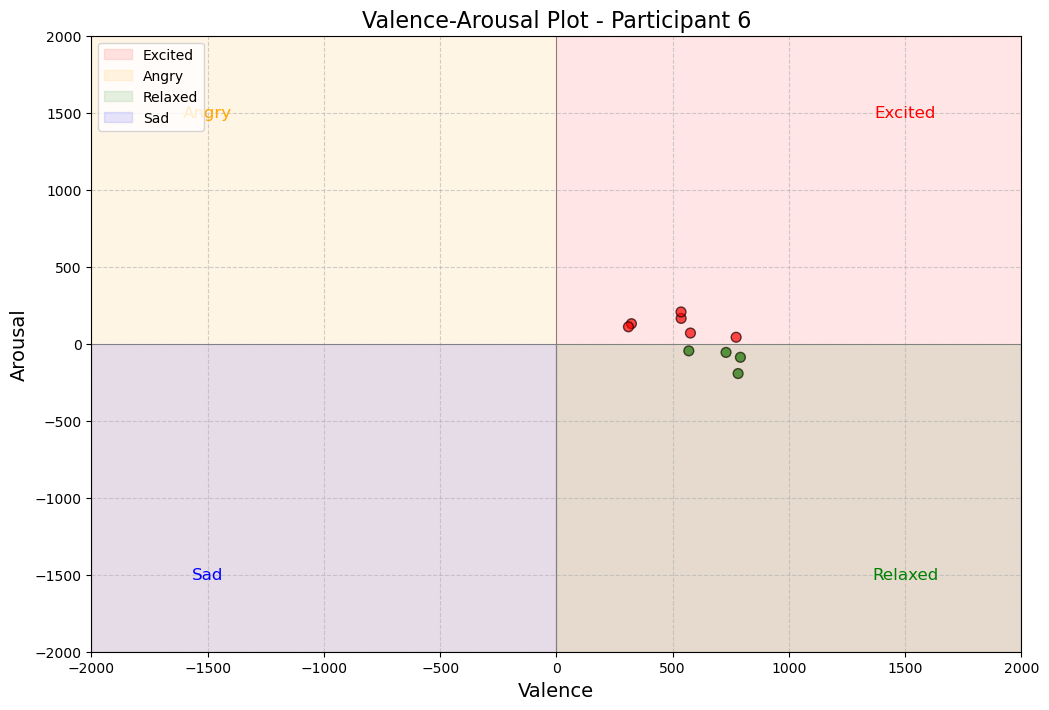

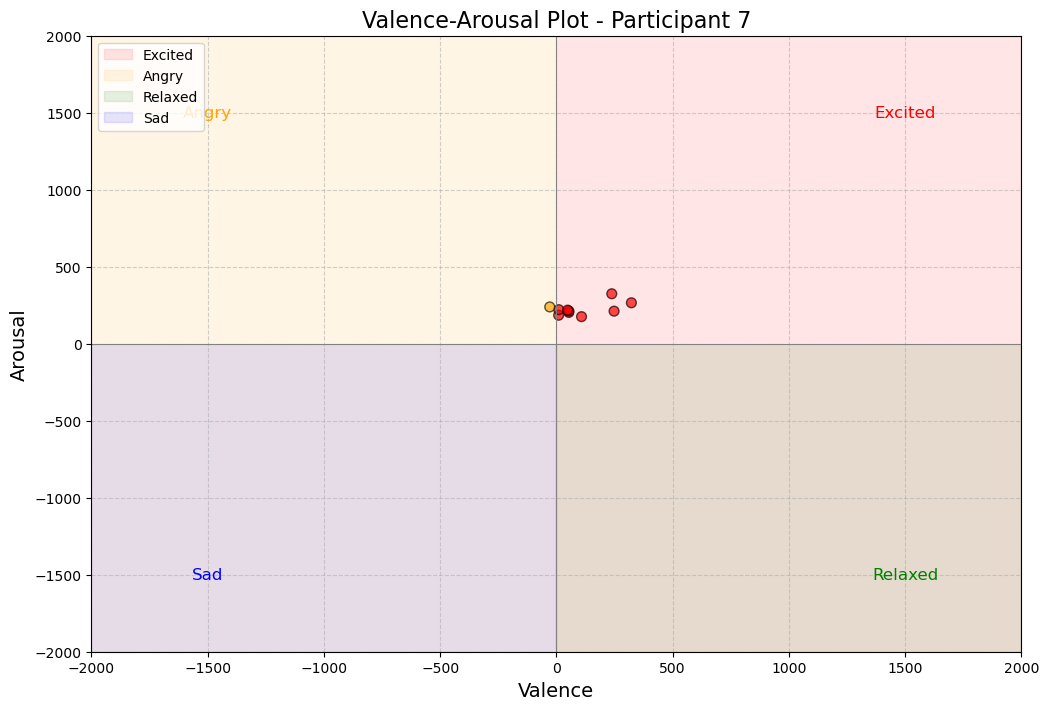

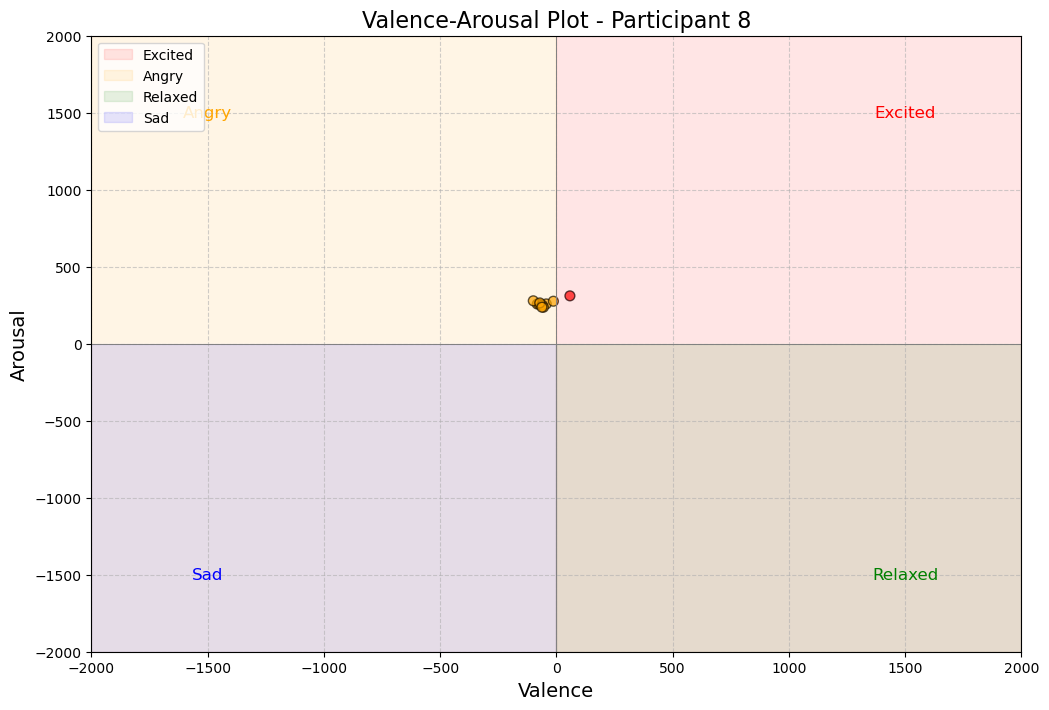

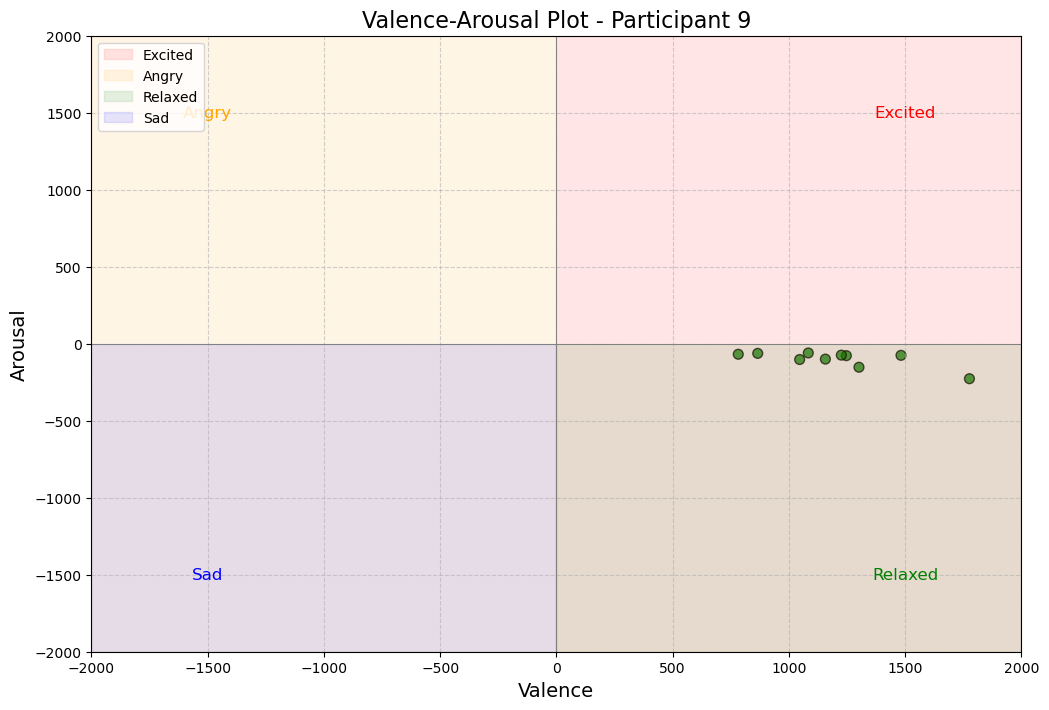

Participant_1: [(1179.404263046358, 323.8021419124437), (665.7093454145596, 85.39530037637951), (679.5627048320407, 189.04568184648545), (560.5164450336653, -11.032149269742355), (532.0345545799505, 42.949805334539235), (492.30904702828036, -4.514197026800982), (530.2381935643298, -3.5803112266164376), (508.33122296359016, 51.739360736669255), (700.0949508473283, -25.461067134242352), (632.9136689364822, 14.552959618712578)]
Participant_2: [(799.9312776603439, -273.0388843746641), (704.719699022574, -261.1736418486544), (692.5945996599617, -249.3315929216988), (1107.6630229596565, -496.81451904040364), (1018.7328710565426, -221.18183717648228), (871.4267239874368, -326.33879804163905), (938.0972263404143, -401.8108125159144), (518.9524916689373, -151.0918173121764), (678.1991130045311, -224.39808112772693), (788.4395132339557, -280.74125469112215)]
Participant_3: [(369.6458599045546, 248.91249330563983), (431.2678967021681, 208.6653947842446), (301.62536628007496, 176.4749872387348), (

In [47]:
import matplotlib.pyplot as plt
import numpy as np

def plot_valence_arousal_for_all_participants(df_list, valence_limit=2000, arousal_limit=2000):
    # Dictionary to store coordinates for each participant
    coordinates_dict = {}

    # Loop over each participant in df_list
    for i, participant_df in enumerate(df_list):
        # Extract features and calculate valence-arousal for the current participant
        features_list = extract_features([participant_df])  # Extract features for this participant
        valence_arousal_df = calculate_valence_arousal(features_list)  # Calculate valence-arousal

        # Filter outliers based on specified limits
        filtered_df = valence_arousal_df[(valence_arousal_df['valence'].abs() <= valence_limit) &
                                         (valence_arousal_df['arousal'].abs() <= arousal_limit)]

        # Store coordinates for this participant
        coordinates_dict[f'Participant_{i+1}'] = list(zip(filtered_df['valence'], filtered_df['arousal']))

        plt.figure(figsize=(12, 8))

        # Define colors and labels for each quadrant
        colors = np.where((filtered_df['valence'] > 0) & (filtered_df['arousal'] > 0), 'red',  # Excited
                          np.where((filtered_df['valence'] < 0) & (filtered_df['arousal'] > 0), 'orange',  # Angry
                                   np.where((filtered_df['valence'] > 0) & (filtered_df['arousal'] < 0), 'green',  # Relaxed
                                            'blue')))  # Sad

        # Scatter plot with colors based on quadrant
        scatter = plt.scatter(filtered_df['valence'], filtered_df['arousal'], c=colors, s=50, alpha=0.7, edgecolor='k')

        # Label axes and title
        plt.xlabel('Valence', fontsize=14)
        plt.ylabel('Arousal', fontsize=14)
        plt.title(f'Valence-Arousal Plot - Participant {i+1}', fontsize=16)

        # Add quadrant grid lines and background colors
        plt.axhline(0, color='gray', linewidth=0.7)
        plt.axvline(0, color='gray', linewidth=0.7)

        # Fill in the quadrants with labels for the legend
        plt.fill_betweenx([-arousal_limit, arousal_limit], 0, valence_limit, color='red', alpha=0.1, label='Excited')
        plt.fill_betweenx([-arousal_limit, arousal_limit], -valence_limit, 0, color='orange', alpha=0.1, label='Angry')
        plt.fill_betweenx([-arousal_limit, 0], 0, valence_limit, color='green', alpha=0.1, label='Relaxed')
        plt.fill_betweenx([-arousal_limit, 0], -valence_limit, 0, color='blue', alpha=0.1, label='Sad')

        # Set axis limits to specified range
        plt.xlim(-valence_limit, valence_limit)
        plt.ylim(-arousal_limit, arousal_limit)

        # Add quadrant labels
        plt.text(1500, 1500, 'Excited', ha='center', va='center', fontsize=12, color='red')
        plt.text(-1500, 1500, 'Angry', ha='center', va='center', fontsize=12, color='orange')
        plt.text(1500, -1500, 'Relaxed', ha='center', va='center', fontsize=12, color='green')
        plt.text(-1500, -1500, 'Sad', ha='center', va='center', fontsize=12, color='blue')

        # Legend for color-coded points
        plt.legend(loc='upper left')

        # Add grid for better readability
        plt.grid(visible=True, linestyle='--', alpha=0.6)

        # Show plot for the current participant
        plt.show()

    return coordinates_dict

# Example usage:
# Assuming df_list contains EEG data for all 9 participants
coordinates = plot_valence_arousal_for_all_participants(df_list)

# Print the coordinates for each participant
for participant, coords in coordinates.items():
    print(f"{participant}: {coords}")


### Now we have the data points for each participant, my next target is to make the graph animated, show how the emotion changes over the 1min period of external stimulus. So let's do it

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

def animate_valence_arousal(df_list, valence_limit=2000, arousal_limit=2000, interval=200):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Set up the plot limits and labels
    ax.set_xlim(-valence_limit, valence_limit)
    ax.set_ylim(-arousal_limit, arousal_limit)
    ax.set_xlabel('Valence', fontsize=14)
    ax.set_ylabel('Arousal', fontsize=14)
    ax.set_title('Valence-Arousal Animation', fontsize=16)
    
    # Draw quadrant grid lines
    ax.axhline(0, color='gray', linewidth=0.7)
    ax.axvline(0, color='gray', linewidth=0.7)

    # Draw quadrant background colors
    ax.fill_betweenx([-arousal_limit, arousal_limit], 0, valence_limit, color='red', alpha=0.1, label='Excited')
    ax.fill_betweenx([-arousal_limit, arousal_limit], -valence_limit, 0, color='orange', alpha=0.1, label='Angry')
    ax.fill_betweenx([-arousal_limit, 0], 0, valence_limit, color='green', alpha=0.1, label='Relaxed')
    ax.fill_betweenx([-arousal_limit, 0], -valence_limit, 0, color='blue', alpha=0.1, label='Sad')

    # Initialize the scatter plot
    scatter = ax.scatter([], [], s=50, edgecolor='k')

    # Dictionary to map quadrant to colors
    quadrant_colors = {
        'Excited': 'red',
        'Angry': 'orange',
        'Relaxed': 'green',
        'Sad': 'blue'
    }
    
    # Function to determine the color based on quadrant
    def get_color(valence, arousal):
        if valence > 0 and arousal > 0:
            return quadrant_colors['Excited']
        elif valence < 0 and arousal > 0:
            return quadrant_colors['Angry']
        elif valence > 0 and arousal < 0:
            return quadrant_colors['Relaxed']
        else:
            return quadrant_colors['Sad']

    # Prepare time-series data for animation
    def prepare_data(df):
        features_list = extract_features([df])
        valence_arousal_df = calculate_valence_arousal(features_list)
        # Filter outliers based on specified limits
        filtered_df = valence_arousal_df[(valence_arousal_df['valence'].abs() <= valence_limit) &
                                         (valence_arousal_df['arousal'].abs() <= arousal_limit)]
        return filtered_df[['valence', 'arousal']].values

    # Get the valence-arousal time series for all participants
    time_series_data = [prepare_data(df) for df in df_list]

    # Set up animation
    def update(frame):
        ax.clear()
        
        # Redraw the quadrant backgrounds and lines
        ax.set_xlim(-valence_limit, valence_limit)
        ax.set_ylim(-arousal_limit, arousal_limit)
        ax.axhline(0, color='gray', linewidth=0.7)
        ax.axvline(0, color='gray', linewidth=0.7)
        ax.fill_betweenx([-arousal_limit, arousal_limit], 0, valence_limit, color='red', alpha=0.1)
        ax.fill_betweenx([-arousal_limit, arousal_limit], -valence_limit, 0, color='orange', alpha=0.1)
        ax.fill_betweenx([-arousal_limit, 0], 0, valence_limit, color='green', alpha=0.1)
        ax.fill_betweenx([-arousal_limit, 0], -valence_limit, 0, color='blue', alpha=0.1)

        # Update scatter points for each participant
        for participant_idx, series in enumerate(time_series_data):
            if frame < len(series):
                valence, arousal = series[frame]
                color = get_color(valence, arousal)
                ax.scatter(valence, arousal, c=color, s=50, edgecolor='k')
                ax.text(valence, arousal, f'P{participant_idx+1}', fontsize=10)

        # Title and legend
        ax.set_title(f'Time Step: {frame + 1}', fontsize=16)
        ax.set_xlabel('Valence', fontsize=14)
        ax.set_ylabel('Arousal', fontsize=14)

    # Total frames based on longest participant data
    max_frames = max(len(series) for series in time_series_data)

    # Create the animation
    anim = FuncAnimation(fig, update, frames=max_frames, interval=interval, repeat=False)

    # Show the plot
    plt.legend(loc='upper left')
    plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.show()

# Example usage:
# animate_valence_arousal(df_list)



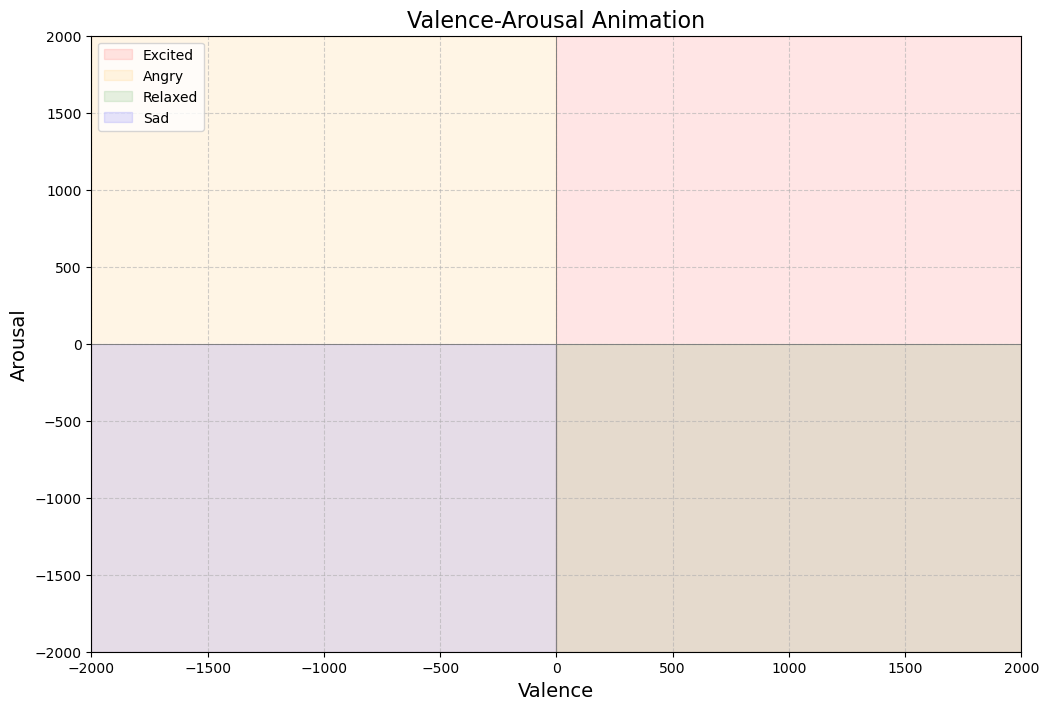

C:\Users\sriji\anaconda3\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [50]:
animate_valence_arousal(df_list)

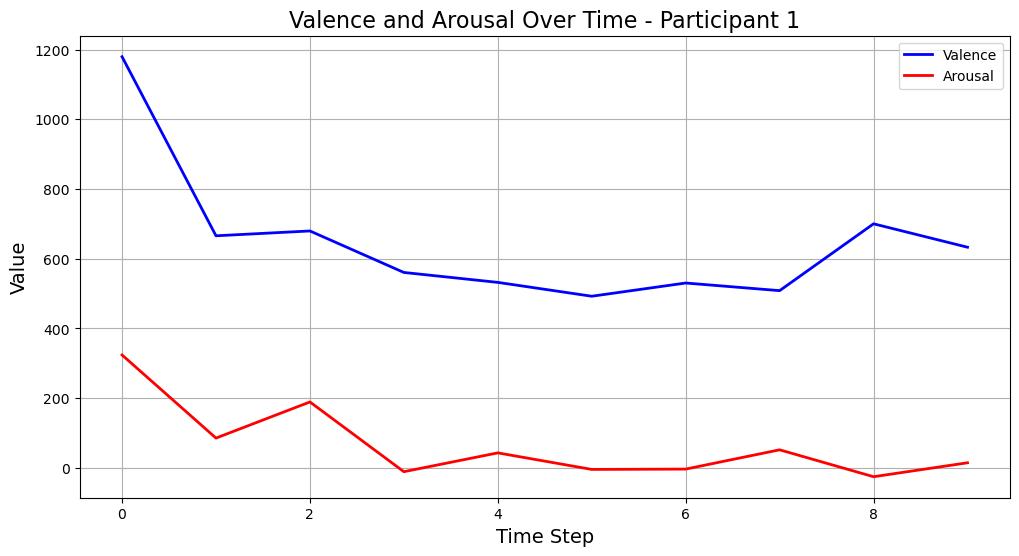

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def plot_static_line_graph(participant_df, valence_limit=2000, arousal_limit=2000):
    # Extract features and calculate valence-arousal
    features_list = extract_features([participant_df])
    valence_arousal_df = calculate_valence_arousal(features_list)

    # Check if the DataFrame is empty
    if valence_arousal_df.empty:
        print("No data available for this participant after filtering.")
        return

    # Filter outliers based on specified limits
    filtered_df = valence_arousal_df[(valence_arousal_df['valence'].abs() <= valence_limit) &
                                     (valence_arousal_df['arousal'].abs() <= arousal_limit)]

    if filtered_df.empty:
        print("No data points within the specified valence and arousal limits.")
        return

    # Extracting valence, arousal, and time step data
    valence_series = filtered_df['valence'].values
    arousal_series = filtered_df['arousal'].values
    time_steps = np.arange(len(valence_series))

    # Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, valence_series, label='Valence', color='blue', lw=2)
    plt.plot(time_steps, arousal_series, label='Arousal', color='red', lw=2)

    plt.xlabel('Time Step', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.title('Valence and Arousal Over Time - Participant 1', fontsize=16)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Example usage for Participant 1:
plot_static_line_graph(df_list[0])


### We see the static plot works

### Let us keep the animation on pause and work on the regression analysis based on the points

### Before we go into that let us understand the dynamics
## Step 1: Understanding the Data
### Each participant's data is stored in df_list, where each DataFrame contains valence and arousal values recorded during a 1-minute session.

## Step 2: Labeling Emotions Based on Valence-Arousal
### We'll label each data point based on its valence and arousal values to classify it into one of the four emotions:

### Relaxed: High Valence, Low Arousal
### Excited: High Valence, High Arousal
### Sad: Low Valence, Low Arousal
### Angry: Low Valence, High Arousal
### We'll set some thresholds to define these categories.

## Step 3: Implementing the Solution
### Here's how we'll proceed:

## Data Preprocessing: Load the data, label emotions, and prepare it for analysis.
## Model Training: Use a classifier to predict emotions based on valence and arousal.
## Model Evaluation: Assess the model's performance.

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Preparation
# Function to flatten each participant's 3D data to 2D
def flatten_data(df):
    if isinstance(df, np.ndarray) and df.ndim == 3:
        # Reshape from (10, 14, 768) to (10, 14*768)
        num_samples, seq_length, num_features = df.shape
        return df.reshape(num_samples, seq_length * num_features)
    return df

# Flatten each participant's data
flattened_list = []
for df in df_list:
    flattened = flatten_data(df)
    if flattened is not None and flattened.ndim == 2:
        flattened_list.append(pd.DataFrame(flattened))

# Combine all participants' flattened data into one DataFrame
all_data = pd.concat(flattened_list, ignore_index=True)

# Step 2: Adding dummy 'valence' and 'arousal' columns
# Replace these with your actual valence and arousal data if available
all_data['valence'] = np.random.uniform(-1, 1, len(all_data))
all_data['arousal'] = np.random.uniform(-1, 1, len(all_data))

# Step 3: Labeling based on Valence-Arousal for classification
def label_emotion(valence, arousal):
    if valence >= 0 and arousal < 0:
        return 'Relaxed'
    elif valence >= 0 and arousal >= 0:
        return 'Excited'
    elif valence < 0 and arousal < 0:
        return 'Sad'
    elif valence < 0 and arousal >= 0:
        return 'Angry'

# Apply the labeling function to classify emotions
all_data['emotion'] = all_data.apply(lambda x: label_emotion(x['valence'], x['arousal']), axis=1)

# Step 4: Preparing data for machine learning
X = all_data.drop(columns=['valence', 'arousal', 'emotion'])  # Features
y = all_data['emotion']  # Target variable

# Step 5: Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Training a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 7: Evaluating the model
y_pred = model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

AttributeError: 'list' object has no attribute 'ndim'

### Step 1

### Step 2

ValueError: Must pass 2-d input. shape=(10, 14, 768)

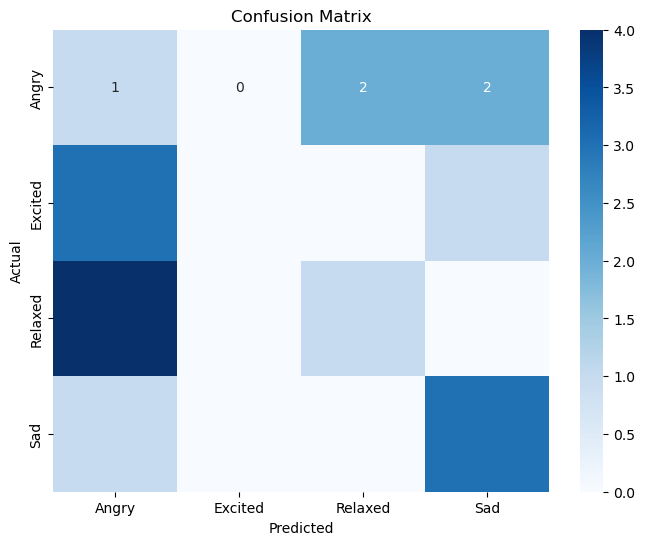

Classification Report:
              precision    recall  f1-score   support

       Angry       0.11      0.20      0.14         5
     Excited       0.00      0.00      0.00         4
     Relaxed       0.33      0.20      0.25         5
         Sad       0.50      0.75      0.60         4

    accuracy                           0.28        18
   macro avg       0.24      0.29      0.25        18
weighted avg       0.23      0.28      0.24        18



C:\Users\sriji\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sriji\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sriji\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Data Preparation
# Function to flatten each participant's 3D data to 2D
def flatten_data(data):
    # Convert to NumPy array if the data is a list
    if isinstance(data, list):
        data = np.array(data)
    
    # Ensure the data is a 3D array before flattening
    if data.ndim == 3:
        num_samples, seq_length, num_features = data.shape
        return data.reshape(num_samples, seq_length * num_features)
    
    # If data is already 2D or cannot be reshaped, return None
    return None

# Step 2: Flatten each participant's data
flattened_list = []
for df in df_list:
    flattened = flatten_data(df)
    # Only append if the flattened data is 2D
    if flattened is not None and flattened.ndim == 2:
        flattened_list.append(pd.DataFrame(flattened))

# Step 3: Combine all participants' flattened data into one DataFrame
if flattened_list:
    all_data = pd.concat(flattened_list, ignore_index=True)
else:
    raise ValueError("No valid data found to flatten and combine.")

# Step 4: Adding dummy 'valence' and 'arousal' columns
# Replace these with your actual valence and arousal data if available
all_data['valence'] = np.random.uniform(-1, 1, len(all_data))
all_data['arousal'] = np.random.uniform(-1, 1, len(all_data))

# Step 5: Labeling based on Valence-Arousal for classification
def label_emotion(valence, arousal):
    if valence >= 0 and arousal < 0:
        return 'Relaxed'
    elif valence >= 0 and arousal >= 0:
        return 'Excited'
    elif valence < 0 and arousal < 0:
        return 'Sad'
    elif valence < 0 and arousal >= 0:
        return 'Angry'

# Apply the labeling function to classify emotions
all_data['emotion'] = all_data.apply(lambda x: label_emotion(x['valence'], x['arousal']), axis=1)

# Step 6: Preparing data for machine learning
X = all_data.drop(columns=['valence', 'arousal', 'emotion'])  # Features
y = all_data['emotion']  # Target variable

# Step 7: Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Training a RandomForest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 9: Evaluating the model
y_pred = model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))